### Imports

In [ ]:
import cv2
import numpy as np
from scipy.spatial import distance

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

### Constants

In [ ]:
PATH_FILE_PLATES = './file/plates.jpg'
PATH_FILE_PLATE_1 = './file/plate-01.jpg'
PATH_FILE_PLATE_2 = './file/plate-02.jpg'

## Plotting Utils

In [232]:

def plot3dSurface(
        fig, axis,
        z: np.array,
        x: np.array = None, y: np.array = None,
        meshGrid: np.array = None,
        position = (),
    ):
    '''
        TODO: 2021-10-27 - ADD Description
    '''

    # Set surface mesh
    if not meshGrid == None and (not x or not y):
        raise AttributeError('No axis provided to plot a surface')

    meshGrid = meshGrid if (meshGrid != None) else np.meshgrid(x, y)
    x, y = meshGrid

    # Create surface
    surf = axis.plot_surface(x, y, z, cmap=cm.Reds)
    fig.colorbar(surf, aspect=5, shrink=.5, ax=axis)

    # axis.set_zlim(-1.01, 1.01)
    axis.zaxis.set_major_locator(LinearLocator(10)) # Alters the grid visible scale
    axis.zaxis.set_major_formatter('{x:.02f}')
    
    # Customize position
    if len(position):
        azim, elev, dist = position
        axis.azim = azim
        axis.elev = elev
        axis.dist = dist

def plot3dSurfacesGrid(
        surfaces: np.array,
        gridRows = 1, gridCols = 1,
        colHeight = 5, colWidth = 5,
        positions = [],
    ) -> None:
    '''
        TODO: 2021-10-27 - Finish Description
        
        About surface positions:

        - Azimuth: Rotation around the z axis;
        - Elev(ation)?: Angle between the eye and the xy plane;
        - Distance: Distance to the center of the surface space;

        Thanks to: https://stackoverflow.com/a/64849390/5959978
    '''
    
    # Build grid
    figHeight = gridRows * colHeight
    figWidth = gridCols * colWidth
    fig, axes = plt.subplots(subplot_kw={"projection": "3d"}, nrows=gridRows, ncols=gridCols, figsize=(figWidth, figHeight))

    # Plot surfaces
    for surfaceNumber in range(0, gridRows):
        for axisNumber in range(0, gridCols):
            x, y, z = surfaces[surfaceNumber]
            a = axes[surfaceNumber, axisNumber] if gridRows > 1 else axes[axisNumber]
            position = positions[axisNumber] if (len(positions) >= axisNumber) else ()
            plot3dSurface(fig=fig, axis=a, x=x, y=y, z=z, position=position)
    
    plt.show()


## Template Matching Class

In [161]:
class TemplateMatching():
    '''
        TODO: 2021-10-27 - ADD Description
    '''

    __img = np.array([])
    __template = np.array([])
    __correlation = np.array([])

    def __init__(self, imgPath: str, templatePath: str) -> None:
        self.__img = self.__readGrayScaleImg(imgPath)
        self.__template = self.__readGrayScaleImg(templatePath)

    def match(self):
        '''
            TODO: 2021-10-27 - ADD Description
        '''


        self.__correlation = cv2.matchTemplate(self.__img, self.__template, cv2.TM_CCOEFF_NORMED)
        return self

    def getCovarMatrix(self) -> np.array:
        '''
            TODO: 2021-10-27 - ADD Description
        '''
        
        return self.__correlation

    def drawRectangle(self, topLeft: tuple, bottomRight: tuple):
        '''
            TODO: 2021-10-27 - ADD Description
        '''
        
        cv2.rectangle(self.__img, topLeft, bottomRight, (255, 0, 0), 1) 
        return self

    def __readGrayScaleImg(self, path: str) -> np.array:
        '''
            TODO: 2021-10-26 - ADD Description
        '''

        imgBgr = cv2.imread(path)
        return np.array(cv2.cvtColor(imgBgr, cv2.COLOR_BGR2GRAY))


## Matching

### Default Open CV

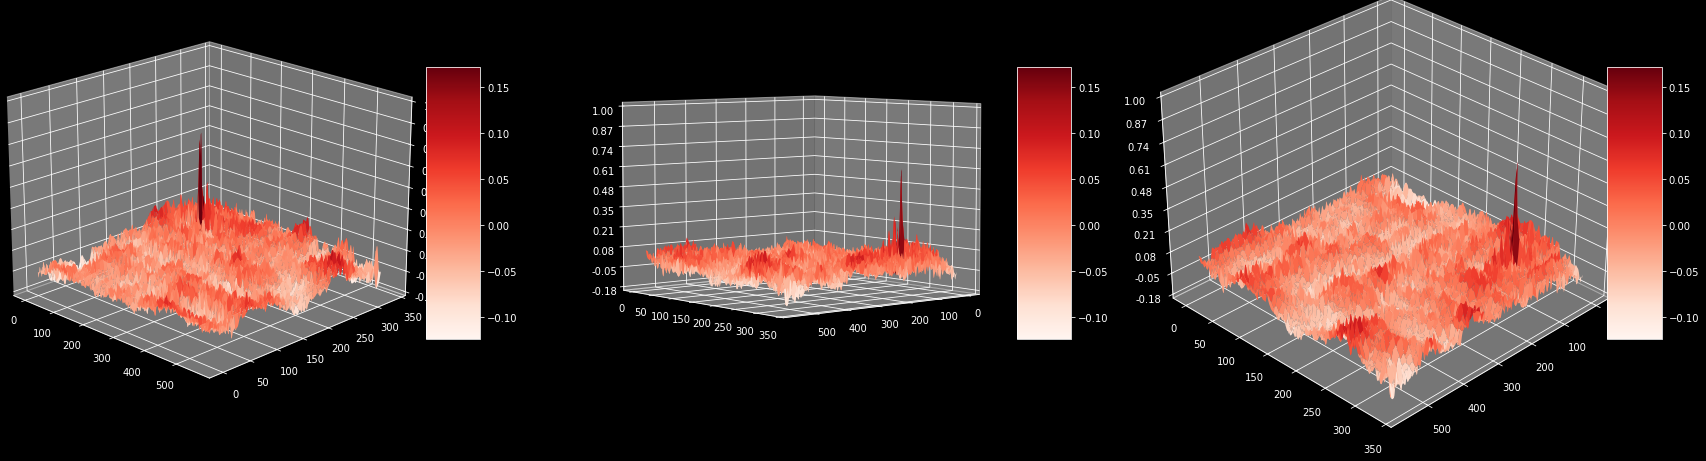

In [236]:

# Do the matching
templateMatcher = TemplateMatching(PATH_FILE_PLATES, PATH_FILE_PLATE_1)
covarMatrix = templateMatcher.match().getCovarMatrix()

# Build grid
meshX = np.arange(0, covarMatrix.shape[1], 1)
meshY = np.arange(0, covarMatrix.shape[0], 1)

surfaces =[]

# Set the squared distances surface
surfaces.append( (meshX, meshY, covarMatrix) )

# Plot surfaces
plot3dSurfacesGrid(
    surfaces=surfaces,
    gridRows = 1, gridCols = 3,
    colHeight = 10, colWidth = 10,
    positions=[(-45, 20, 9), (50, 5, 10), (45, 30, 8)]
)

### Minkowski Distance

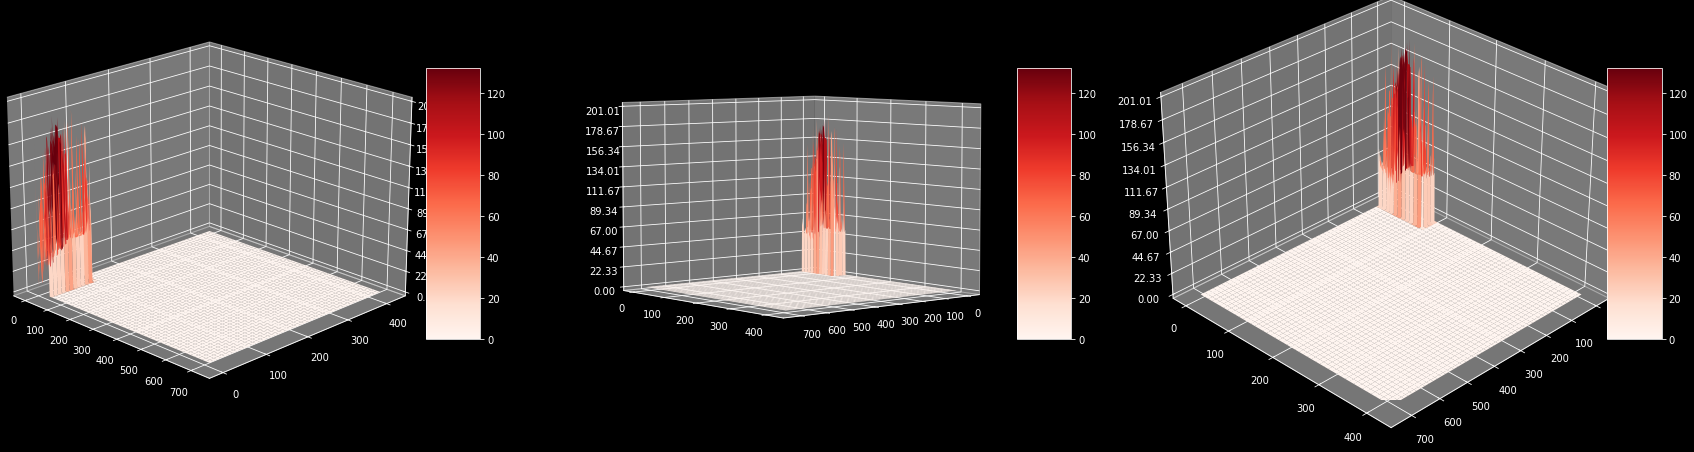

In [235]:
# Read images
img_rgb = cv2.imread(PATH_FILE_PLATES)
template = cv2.imread(PATH_FILE_PLATE_1)

# Do the matching
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

template_gray.shape
covarMatrix = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)
covarMatrix.shape

imgWidth, imgHeight = img_gray.shape
templateWidth, templateHeight = template_gray.shape
fuckingMatrix = np.zeros( (imgWidth, imgHeight) )

mikowskiPower = 6
caray = 50
for imgX in range(0, imgWidth - templateWidth):

    if imgX > caray:
        break

    for templateX in range(0, templateWidth):
        x = imgX + templateX

        if templateX > caray:
            break

        for imgY in range(0, imgHeight - templateHeight):

            if imgY > caray:
                break

            for templateY in range(0, templateHeight):
                y = imgY + templateY

                if y > caray:
                    break

                imgVec = [x, y, img_gray[x, y]]
                templateVec = [templateX, templateY, template_gray[templateX, templateY]]
                fuckingMatrix[x, y] = distance.minkowski(imgVec, templateVec, p=mikowskiPower)


# fuckingMatrix.shape

# Build grid
meshX = np.arange(0, fuckingMatrix.shape[1], 1)
meshY = np.arange(0, fuckingMatrix.shape[0], 1)

# Plot surfaces
plot3dSurfacesGrid(
    surfaces=[(meshX, meshY, fuckingMatrix)],
    gridRows = 1, gridCols = 3,
    colHeight = 10, colWidth = 10,
    positions=[(-45, 20, 9), (50, 5, 10), (45, 30, 8)]
)